<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/qmregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 148 (delta 58), reused 119 (delta 39), pack-reused 0
Receiving objects: 100% (148/148), 16.87 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (58/58), done.


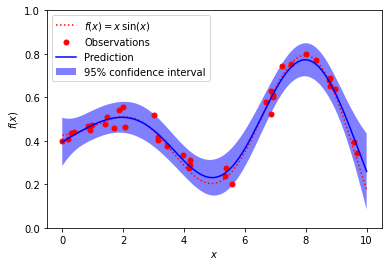

(1000, 1)


In [2]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as pl

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

x = np.atleast_2d(np.linspace(0, 10, 1000)).T

#X = np.linspace(0.1, 9.9, 20)
X = 10* np.random.random(40)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape[0])
noise = np.random.normal(0, dy)
y += noise
scaler = MinMaxScaler((0.2, 0.8))
y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Instantiate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha= 0.01,# dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

In [3]:
import qmc.tf.layers as layers
import qmc.tf.models as models
import tensorflow as tf



/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.CrossProduct.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.DensityMatrix2Dist.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.DensityMatrixRegression.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


2/2 [==============================] - 0s 2ms/step


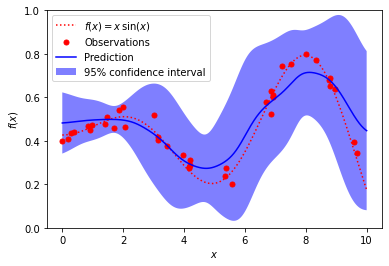

(1000, 1)


In [5]:
X = X.reshape((-1, 1))
dim_x = 100
dim_y = 5
fm_x = layers.QFeatureMapRFF(1, dim=dim_x, gamma=1, random_state=1)
fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=120)
qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
qmr.compile()
y1 = y.reshape(-1, 1)
qmr.fit(X, y1, epochs=1)
#out = qmr.predict(x.reshape((-1, 1)))

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
out = qmr.predict(x.reshape((-1, 1)))
y_pred, sigma = out[:, 0], np.sqrt(out[:, 1])
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

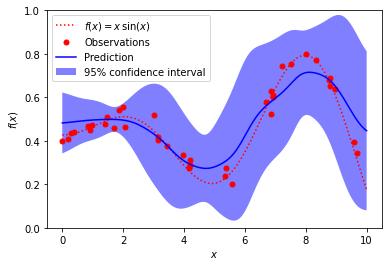

(1000, 1)


In [6]:
qmr1 = models.QMRegressorSGD(input_dim=1, dim_x=dim_x, num_eig=15, dim_y=dim_y, gamma=1, random_state=1)
eig_vals = qmr1.set_rho(qmr.get_rho())

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
out = qmr1.predict(x.reshape((-1, 1)))
y_pred, sigma = out[:, 0], np.sqrt(out[:, 1])
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99999976>

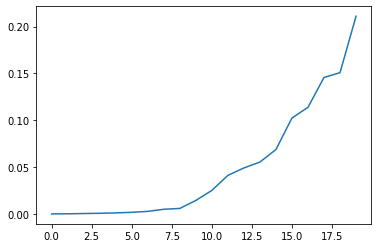

In [7]:
import tensorflow as tf
pl.plot(eig_vals[-20:])
tf.reduce_sum(eig_vals)

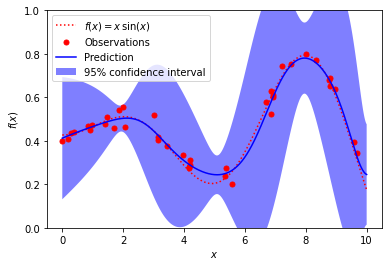

(1000, 1)


In [19]:
dim_x = 100
sigma = 4
gamma = 1. / sigma ** 2
dim_y = 5
alpha = 0.02
fm_x = layers.QFeatureMapRFF(1, dim=dim_x, gamma=gamma, random_state=1)
qmr2 = models.QMRegressorSGD(input_dim=1, dim_x=dim_x, num_eig=15, dim_y=dim_y, gamma=gamma, random_state=1)

# initialize weights
#qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
#qmr.compile()
#qmr.fit(X, y1, epochs=1)
#eig_vals = qmr2.set_rho(qmr.get_rho())


# Train model with SGD
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
qmr2.layers[0].trainable = False

def loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) +  alpha * y_pred[:, 1:2]

qmr2.compile(optimizer, loss=loss)
qmr2.fit(X, y1, epochs=300, verbose=0)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
out = qmr2.predict(x.reshape((-1, 1)))
y_pred, std = out[:, 0], np.sqrt(out[:, 1])
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * std, y_pred + 1.9600 * std,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)